<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_on_unit_sphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE with Von Mises-Fisher distribution

Variational Autoencoder Model (VAE) (https://arxiv.org/pdf/1312.6114.pdf) with the Von Mises–Fisher distribution (https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution) in the latent space. 

https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/VonMisesFisher

In [1]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import colorlover as cl
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=5000, centers=5, n_features=32,random_state=1)

In [0]:
def normalize_data(X):
  return (X-np.mean(X,axis=0)/np.std(X,axis=0))

In [0]:
X = normalize_data(X)

In [0]:
#Multivariate diagional
def create_encoder(inpt, latent_size, activation):
  x = inpt
  x = tf.layers.dense(x, 16, activation)
  x = tf.layers.dense(x, 8, activation)
  x = tf.layers.dense(x, 4, activation)
  direction = tf.layers.dense(x,latent_size)
  direction = direction/tf.norm(direction, axis=-1, keepdims=True)
  return tfd.VonMisesFisher(mean_direction=direction, concentration=25.0)

def create_prior(latent_size):
  return tfd.VonMisesFisher(mean_direction=[0., 0., 1.], concentration=0.)

def create_decoder(inpt, output_size, activation):
  x = inpt
  x = tf.layers.dense(x, 4, activation)
  x = tf.layers.dense(x, 8, activation)
  x = tf.layers.dense(x, 16, activation)
  loc = tf.layers.dense(x, output_size)
  scale = tf.ones(output_size)
  return tfd.MultivariateNormalDiag(loc, scale)

In [6]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x')
latent_size = 3

latent_prior = create_prior(latent_size=latent_size)
latent_posterior = create_encoder(x, latent_size, tf.nn.elu)

latent_sampled = latent_posterior.sample()
latent_mean = latent_posterior.mean()

posterior = create_decoder(latent_sampled, X.shape[1], tf.nn.elu)

posterior_sampled = posterior.sample()
posterior_mean = posterior.mean()

rec_loss = -tf.reduce_mean(posterior.log_prob(x))
#kl = tf.reduce_mean(tfd.kl_divergence(latent_posterior, latent_prior)) #analytical
kl = tf.reduce_mean(latent_posterior.log_prob(latent_sampled)- latent_prior.log_prob(latent_sampled)) #approximate KL
beta=1.0
kl_loss = beta*kl
loss = rec_loss + kl_loss
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

W0703 15:12:58.980872 140281328158592 deprecation.py:323] From <ipython-input-5-8c2dbccf5291>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0703 15:12:58.985472 140281328158592 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0703 15:12:59.330758 140281328158592 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/von_mises_fisher.py:367: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0

In [0]:
#Helper function
def batch_generator(features, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:]

In [8]:
n_epochs = 30
batch_size = 25
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    gen = batch_generator(X, batch_size) #create batch generator
    total_loss = 0
    total_rec_loss = 0
    for j in range(np.int(X.shape[0]/batch_size)):
      x_batch = gen.__next__()
      _, total_loss_, total_rec_loss_ = sess.run([optimizer, loss, rec_loss], feed_dict={x: x_batch})
      total_loss += total_loss_
      total_rec_loss += total_rec_loss_
    if (i+1)% 10 == 0 or i == 0:
      #latent_mean_, latent_sampled_, posterior_mean_, posterior_sampled_= sess.run([latent_mean, latent_sampled, posterior_mean, posterior_sampled], feed_dict ={x:X})
      end = time.time()
      print('epoch: {0}, total_loss: {1:.2f}, rec_loss: {2:.2f}, time: {3:.2f}'.format((i+1), 
                                       total_loss/(1+np.int(X.shape[0]/batch_size)), total_rec_loss/(1+np.int(X.shape[0]/batch_size)), end-start))
      start = time.time()
  latent_mean_, latent_sampled_, posterior_mean_, posterior_sampled_= sess.run([latent_mean, latent_sampled, posterior_mean, posterior_sampled], feed_dict ={x:X})

epoch: 1, total_loss: 546.25, rec_loss: 543.38, time: 4.78
epoch: 10, total_loss: 58.47, rec_loss: 55.58, time: 6.51
epoch: 20, total_loss: 53.36, rec_loss: 50.48, time: 7.03
epoch: 30, total_loss: 51.02, rec_loss: 48.09, time: 7.06


In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

configure_plotly_browser_state()

init_notebook_mode(connected=False)


import plotly.graph_objs as go


trace1 = go.Scatter3d(
    x=latent_sampled_[:,0],
    y=latent_sampled_[:,1],
    z=latent_sampled_[:,2],
    name = 'train data: line',
    mode='markers',
    marker=dict(
        size=2,
        color=y,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.8
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)



fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

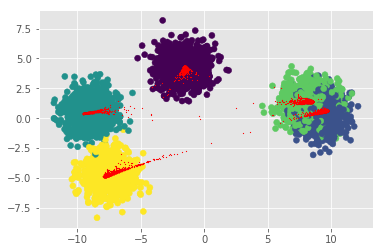

In [9]:
plt.scatter(X[:,0], X[:,1], c=y);
plt.scatter(posterior_mean_[:,0],posterior_mean_[:,1], c='red', s=0.5);

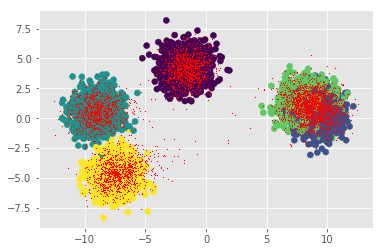

In [10]:
plt.scatter(X[:,0], X[:,1], c=y);
plt.scatter(posterior_sampled_[:,0],posterior_sampled_[:,1], c='red', s=0.5);